# Mục mới

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [ ]:
df = pd.read_csv('ETH-USD.csv')
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,136.836243,138.995270,136.434784,136.443619,136.443619,3756124824
1,2019-03-02,136.350082,137.184799,132.436386,134.206955,134.206955,3747176425
2,2019-03-03,134.786118,135.849289,131.328857,132.249420,132.249420,3454374053
3,2019-03-04,132.157883,132.729141,125.402702,127.774124,127.774124,4008171341
4,2019-03-05,127.792953,138.229980,126.735298,137.822388,137.822388,4764849990


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

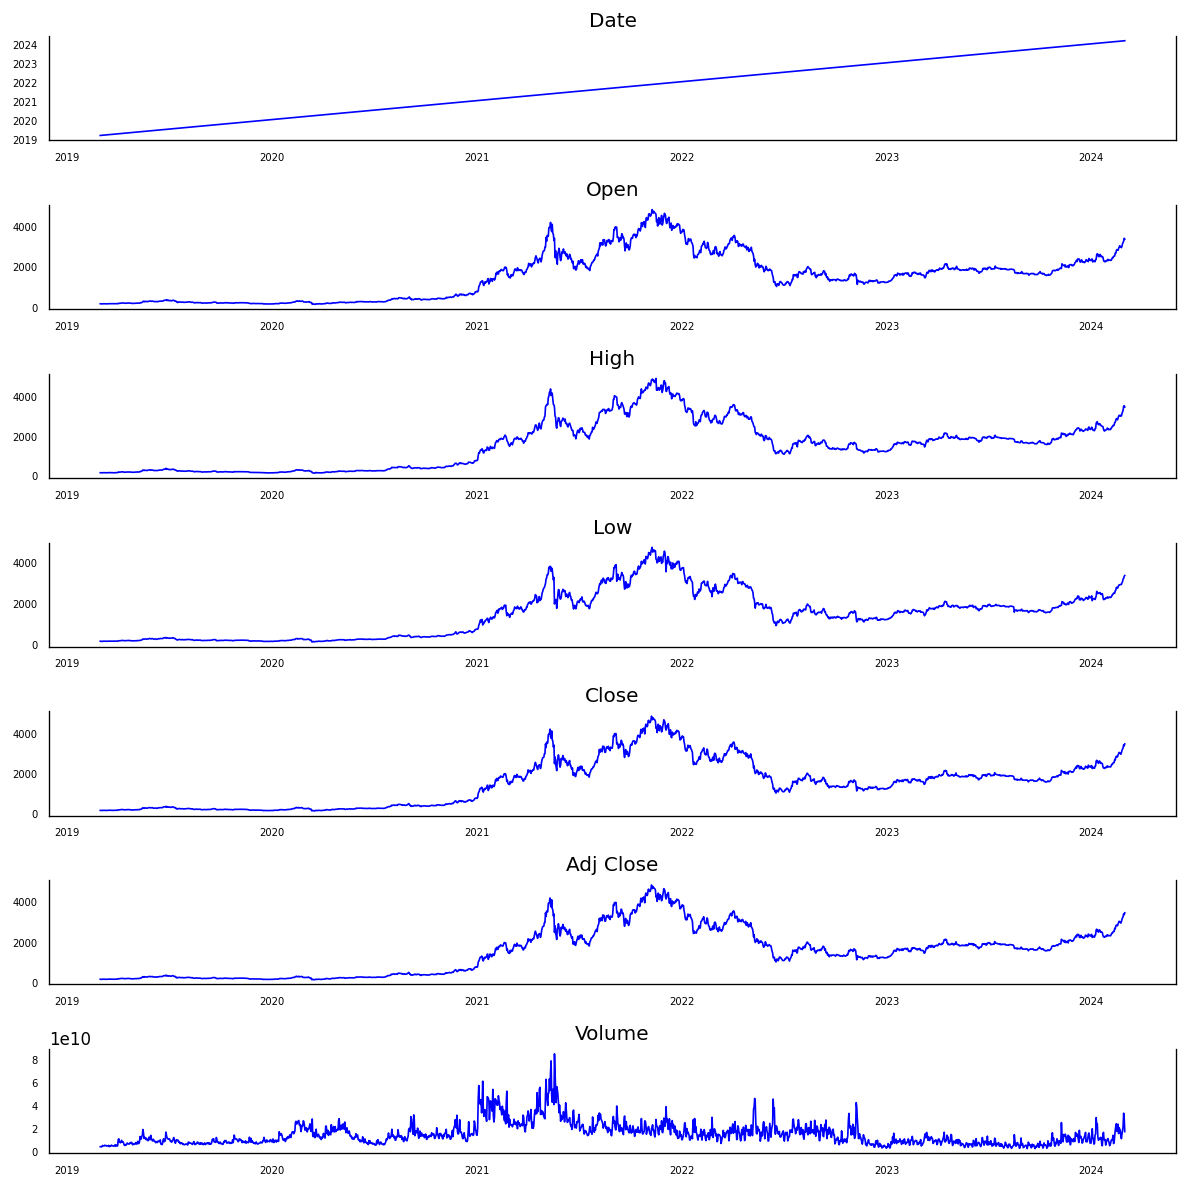

In [ ]:
fig, axes = plt.subplots(nrows=7, ncols=1, dpi=120, figsize=(10,10))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(df.Date, data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

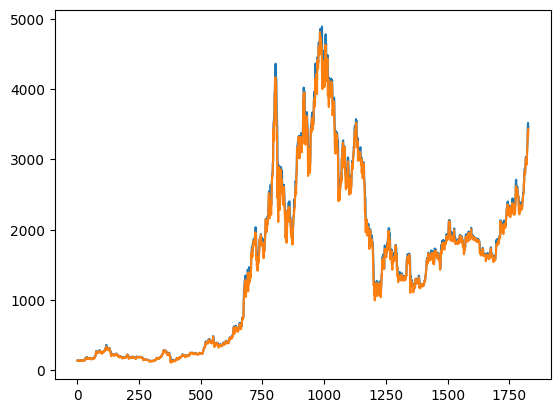

In [ ]:
y = df[["Close"]]
X= df[["High"]]
plt.plot(X)
plt.plot(y)
plt.show()

In [ ]:
# 9:1
train_size = int(0.9 * len(df))
test_size = len(df) - train_size

y_train = y[:train_size]
X_train = X[:train_size]
y_test = y[train_size:]
X_test = X[train_size:]



In [ ]:
# Chọn các cột 'Open', 'High', 'Low', 'Close', 'Adj Close', và 'Volume' từ DataFrame
cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
time_series = df[cols]

# Chia dữ liệu thành tập train và tập test
train_data = time_series[:int(0.9*len(time_series))]
test_data = time_series[int(0.9*len(time_series)):]

In [ ]:
# Xây dựng mô hình VAR
model = VAR(train_data)

In [ ]:
# Phù hợp mô hình với dữ liệu train và chọn một giá trị tự động cho order
model = VAR(train_data)
fitted_model = model.fit()

In [ ]:
train_data

,Open,High,Low,Close,Adj Close,Volume
0,136.836243,138.995270,136.434784,136.443619,136.443619,3756124824
1,136.350082,137.184799,132.436386,134.206955,134.206955,3747176425
2,134.786118,135.849289,131.328857,132.249420,132.249420,3454374053
3,132.157883,132.729141,125.402702,127.774124,127.774124,4008171341
4,127.792953,138.229980,126.735298,137.822388,137.822388,4764849990
...,...,...,...,...,...,...
1640,1646.271973,1659.267090,1645.902832,1657.513062,1657.513062,2624065031
1641,1657.439819,1659.328735,1627.446777,1652.457397,1652.457397,4855588534
1642,1652.274170,1742.637329,1639.576172,1729.725708,1729.725708,11304916729
1643,1729.676636,1730.564697,1697.147217,1705.112183,1705.112183,5023904190


In [ ]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

# Chọn các cột 'Open', 'High', 'Low', 'Close', 'Adj Close', và 'Volume' từ DataFrame
cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
data_series = df[cols]

# Áp dụng hàm adfuller_test cho từng cột
for col in data_series.columns:
    adfuller_test(data_series[col], name=col)

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.2388
 No. Lags Chosen       = 17
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.6567. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.2785
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.639. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. 

In [ ]:
last_row = df.tail(1)
last_data = (last_row['High']).values.reshape(-1,1)
last_data

array([[3452.626221]])

In [ ]:
# lag_order = 9
fitted_model = model.fit(9)
lag_order = fitted_model.k_ar
predictions = fitted_model.forecast(train_data.values[-lag_order:], steps=len(test_data))

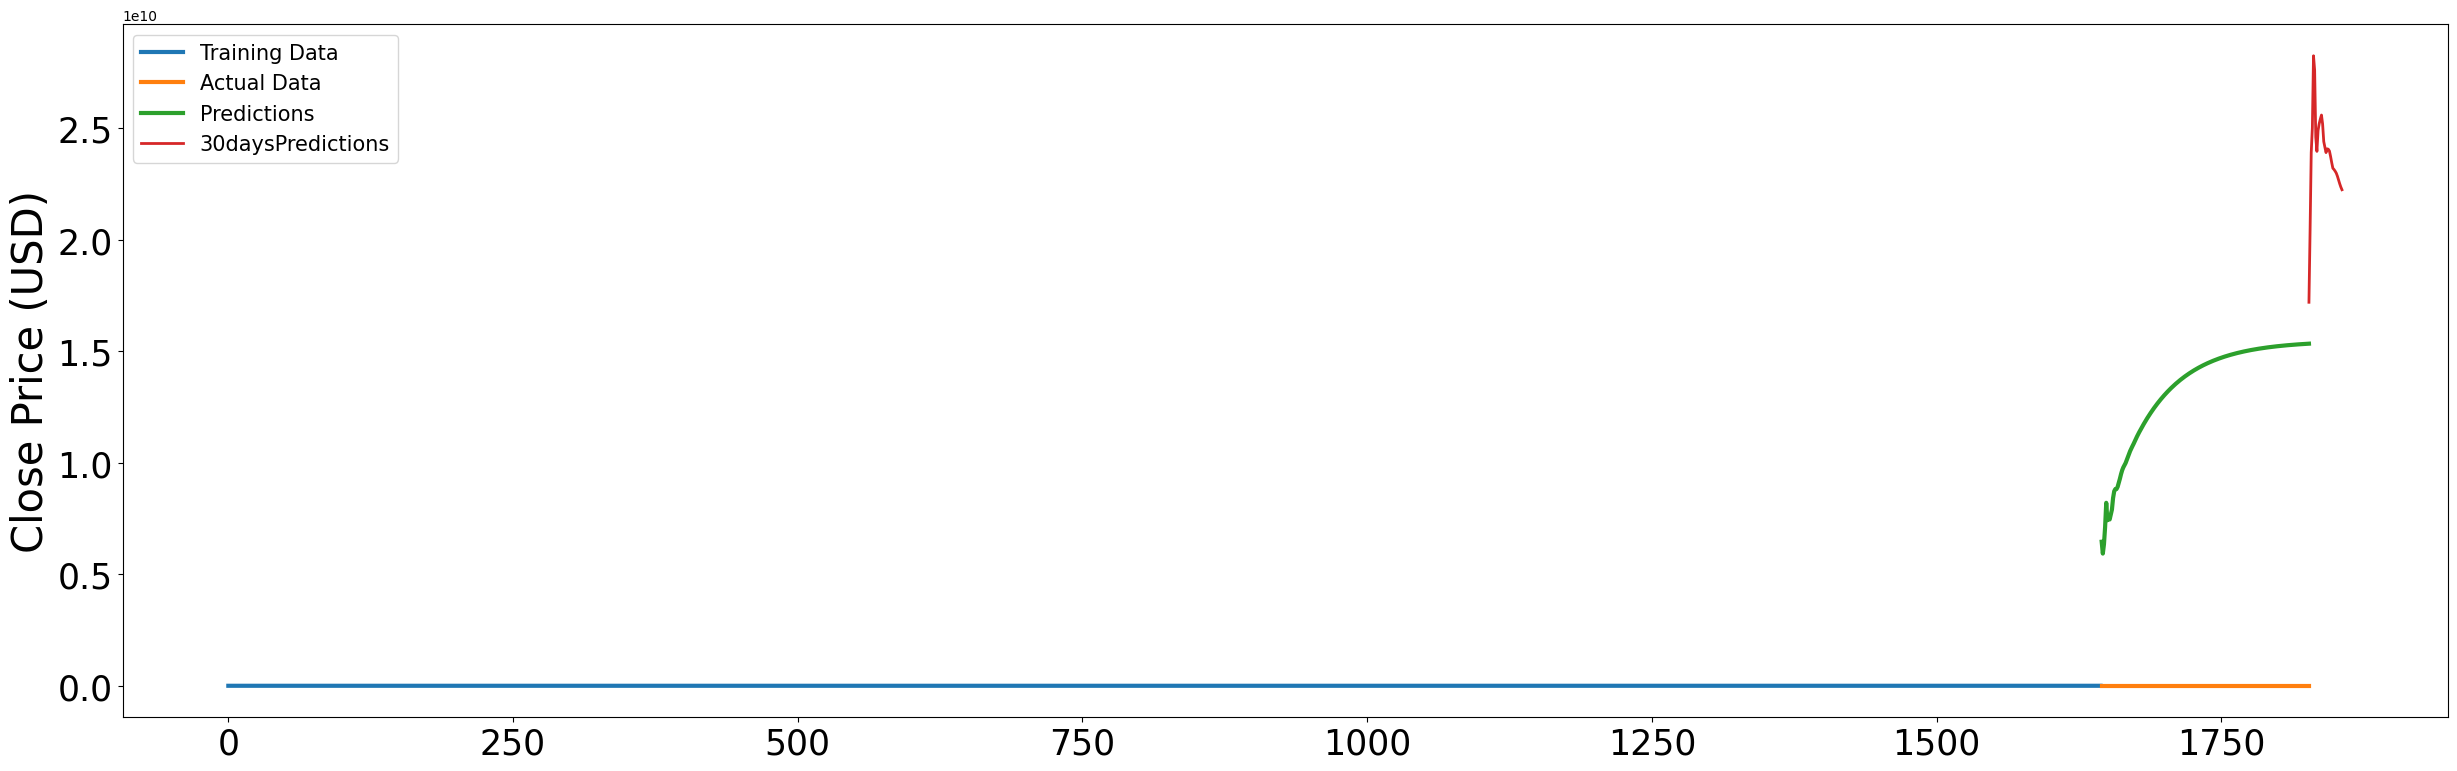

In [ ]:
plt.figure(figsize=(30, 9))
plt.plot(train_data.index, train_data.Close, label='Training Data', linewidth=3)
plt.plot(test_data.index, test_data.Close, label='Actual Data', linewidth=3)
plt.plot(test_data.index, predictions[:,5], label='Predictions', linewidth=3)

# Dự đoán 30 ngày tiếp theo
predictions_future = fitted_model.forecast(test_data.values[-lag_order:], steps=30)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(prediect_data_index, predictions_future[:,5], label='30daysPredictions', linewidth=2)


plt.ylabel('Close Price (USD)', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=15)
plt.show()

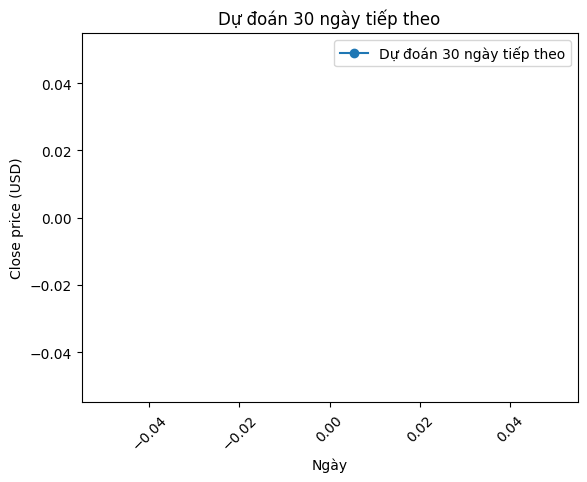

In [59]:
plt.plot(x_next_30_day, marker='o', label='Dự đoán 30 ngày tiếp theo')

plt.title('Dự đoán 30 ngày tiếp theo')
plt.xlabel('Ngày')
plt.ylabel('Close price (USD)')
plt.xticks(rotation=45)
plt.legend()

plt.show()